# Molecular Tastants
Bogna Kilanowska 148252
https://www.kaggle.com/competitions/molecular-tastants

## Project setup
- load data
- load libs

In [1]:
import numpy as np 

np.random.seed(973)

In [2]:
import pandas as pd

df = pd.read_csv('data/train.csv')
df.head()

,molecule_id,smiles,taste
0,train_0,C=C1CC23CCC4C(C)(C(=O)O)CCCC4(C)C2CCC1(OC1OC(C...,6
1,train_1,Nc1ccccc1NS(=O)(=O)[O-].[Na+],3
2,train_2,O=C1NS(=O)(=O)c2cc(O)ccc21,6
3,train_3,OCC1OC(Oc2ccc3ccccc3c2)C(O)C(O)C1O,0
4,train_4,CCC1(C2=CCCCCC2)C(=O)NC(=O)NC1=O,0


## Preliminary data analysis

In [3]:
df.shape

(1809, 3)

In [4]:
print(df.isna().sum())
print(df.isnull().sum())

molecule_id    0
smiles         0
taste          0
dtype: int64
molecule_id    0
smiles         0
taste          0
dtype: int64


taste
0    731
6    589
3    149
7    125
2     69
8     63
1     50
5     25
4      8
Name: count, dtype: int64


array([[<Axes: title={'center': 'taste'}>]], dtype=object)

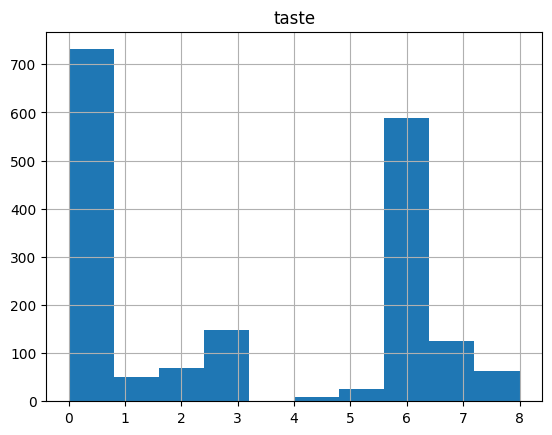

In [5]:
print(df.taste.value_counts())
df.hist(column='taste')

## Data pre-processing

In [6]:
from skfp.fingerprints import AtomPairFingerprint
atom_pair_fingerprint = AtomPairFingerprint()
fp = atom_pair_fingerprint.transform(df.smiles)
X = pd.DataFrame(fp)
X

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1,1,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1805,1,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1807,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Simple approach

### Train test split

In [43]:
from skfp.fingerprints import ECFPFingerprint
from collections import Counter
from skfp.model_selection import scaffold_train_test_split

mols_train, mols_test, y_train, y_test = scaffold_train_test_split(df.smiles, df.taste, test_size=0.2)
print(f'Classes distribution train: {sorted(Counter(y_train).items())}')
print(f'Classes distribution test: {sorted(Counter(y_test).items())}')

ecfp_fp = ECFPFingerprint()
X_train = ecfp_fp.transform(mols_train)
X_test = ecfp_fp.transform(mols_test)

Classes distribution train: [(0, 519), (1, 40), (2, 63), (3, 143), (4, 8), (5, 24), (6, 493), (7, 102), (8, 55)]
Classes distribution test: [(0, 212), (1, 10), (2, 6), (3, 6), (5, 1), (6, 96), (7, 23), (8, 8)]


### Model

In [44]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def train_model(X_train, X_test, y_train, y_test):

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = balanced_accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8])
    print(f"Balanced accuracy: {acc:.2%}")

    return cm



In [45]:
cm = train_model(X_train, X_test, y_train, y_test)

Balanced accuracy: 40.47%


### Confusion matrix

In [46]:
import matplotlib.pyplot as plt

def plot_cm(cm):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8])
    cm_display.plot()
    plt.show() 

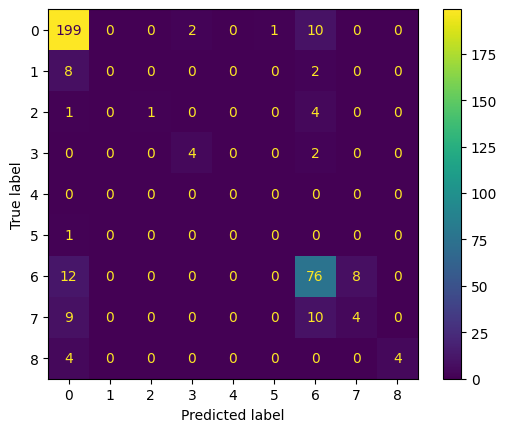

In [47]:
plot_cm(cm)

## Balancing classes

In [51]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

sme = SMOTE()

print(f'Classes distribution : {sorted(Counter(y_train).items())}')

X_resampled, y_resampled = sme.fit_resample(X_train, y_train)

print(f'Classes distribution : {sorted(Counter(y_resampled).items())}')
print(X_resampled)

Classes distribution : [(0, 519), (1, 40), (2, 63), (3, 143), (4, 8), (5, 24), (6, 493), (7, 102), (8, 55)]
Classes distribution : [(0, 519), (1, 519), (2, 519), (3, 519), (4, 519), (5, 519), (6, 519), (7, 519), (8, 519)]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


(1809, 1)
Classes distribution : [(0, 731), (1, 50), (2, 69), (3, 149), (4, 8), (5, 25), (6, 589), (7, 125), (8, 63)]
Classes distribution : [(0, 731), (1, 731), (2, 731), (3, 731), (4, 731), (5, 731), (6, 731), (7, 731), (8, 731)]
[   0    1    2 ...  358 1009  558]
taste
0    2500
6    2069
3     591
7     500
2     284
8     252
1     213
5     143
4      27
Name: count, dtype: int64


array([[<Axes: title={'center': 'taste'}>]], dtype=object)

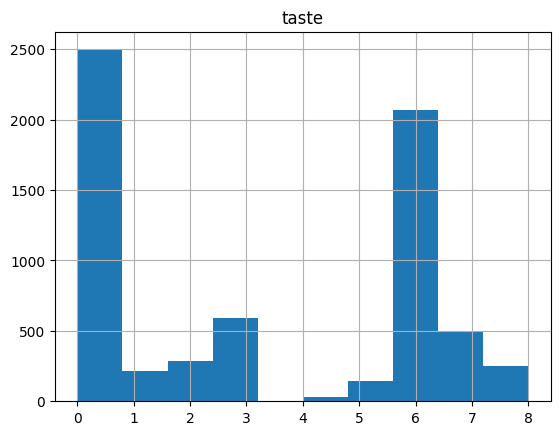

In [50]:
### PROBLEM Z DYSTRYBUCJĄ KLAS - HELP
# TODO

sme = SMOTE()

df_idx = np.array(np.arange(0, len(df)))
df_idx = df_idx.reshape(-1, 1)
print(df_idx.shape)

print(f'Classes distribution : {sorted(Counter(df.taste).items())}')

_X_resampled, _y_resampled = sme.fit_resample(df_idx, df.taste)

print(f'Classes distribution : {sorted(Counter(_y_resampled).items())}')
print(_X_resampled.flatten())

_df_balanced = df.iloc[_X_resampled.flatten()]

print(_df_balanced.taste.value_counts())
_df_balanced.hist(column='taste')

In [ ]:
cm_2 = train_model(X_resampled, X_test, y_resampled, y_test)

Balanced accuracy: 46.44%


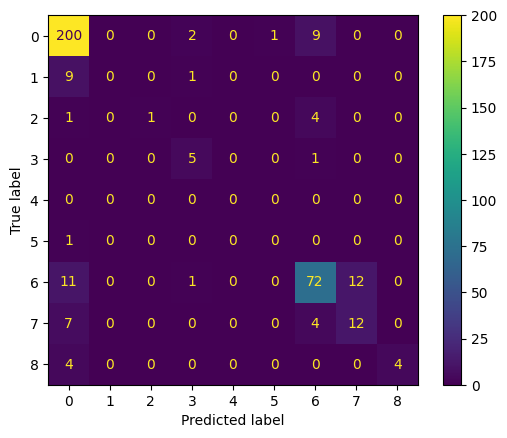

In [53]:
plot_cm(cm_2)

## Model building

## Model training

## Making predictions

## Visualising results
